In [4]:
cd '/home/schlecker/repos/planeteScripts'

/home/schlecker/repos/planeteScripts


In [5]:
%load_ext autoreload
%autoreload 2
from make_list import *
from planeteOutput import *
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
# load an example population
popfile = '/home/schlecker/phd/planete/outputs/bernNov17/popu/popu.hdf5'
j35file = '/home/schlecker/phd/planete/outputs/J35/pop04f_J35.hd5'
pop = read_popHdf5(j35file, hierarchical=False, nSample=5)

SIM1515
SIM6010
SIM8511
SIM9792
SIM9845


In [31]:
T1simFile = '/home/schlecker/phd/planete/outputs/singleruns/01Trappist1/'
T1sim = read_simFromFolder(T1simFile)

Reading files: /home/schlecker/phd/planete/outputs/singleruns/01Trappist1//tracks*.outputdat
Reading planet001...
Reading planet002...
Reading planet003...
Reading planet004...
Reading planet005...
Reading planet006...
Reading planet007...
Reading planet008...
Reading planet009...
Reading planet010...
Reading planet011...
Reading planet012...
Reading planet013...
Reading planet014...
Reading planet015...
Reading planet016...
Reading planet017...
Reading planet018...
Reading planet019...
Reading planet020...
Reading planet021...
Reading planet022...
Reading planet023...
Reading planet024...
Reading planet025...
Reading planet026...
Reading planet027...
Reading planet028...
Reading planet029...
Reading planet030...
Reading planet031...
Reading planet032...
Reading planet033...
Reading planet034...
Reading planet035...
Reading planet036...
Reading planet037...
Reading planet038...
Reading planet039...
Reading planet040...
Reading planet041...
Reading planet042...
Reading planet043...
Read

In [36]:
def plot_planetTracks(simulation):

    # dirty hack to get round line caps
    from matplotlib.backend_bases import GraphicsContextBase, RendererBase
    class GC(GraphicsContextBase):
        def __init__(self):
            super().__init__()
            self._capstyle = 'round'

    def custom_new_gc(self):
        return GC()
    RendererBase.new_gc = types.MethodType(custom_new_gc, RendererBase)
    
    
    from matplotlib.collections import LineCollection
    fig, ax = plt.subplots()

    for df in simulation:
        planet = simulation[df]
        
        # exclude planets that never grew
        if max(planet['m']) < 50.0:
            print('exclude {}: too small'.format(planet.name))
            continue
        
        t = planet['t'][::10]
        a = planet['a'][::10]
        m = planet['m'][::10]
        r = planet['r'][::10]
        
        # linearly transform widths into different range
        rRange = (min(r), max(r))
        lwRange = (0., 5.)
        lw = (r - rRange[0])/(rRange[1] - rRange[0])*(lwRange[1] - lwRange[0]) + lwRange[0] 
        
        # create a set of line segments
        points = np.array([t, a]).T.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)
        lc = LineCollection(segments, linewidths=lw, cmap='inferno_r', norm=plt.Normalize(min(m), max(m)))
        lc.set_array(m)
        ax.add_collection(lc)
    
    # add a colorbar
    cbar = plt.colorbar(segments)
    cbar.set_label('Planet Mass [$\mathrm{M_{Earth}}$]')
    
    ax.set_xscale('log')
    return fig, ax

In [37]:
fig, ax = plot_planetTracks(T1sim)
fig.savefig('/home/schlecker/Desktop/T1.svg', rasterized=True)

exclude planet001: too small
exclude planet002: too small
exclude planet003: too small
exclude planet004: too small
exclude planet005: too small
exclude planet006: too small
exclude planet007: too small
exclude planet008: too small
exclude planet009: too small
exclude planet010: too small
exclude planet011: too small
exclude planet012: too small
exclude planet013: too small
exclude planet014: too small
exclude planet015: too small
exclude planet016: too small
exclude planet017: too small
exclude planet018: too small
exclude planet019: too small
exclude planet020: too small
exclude planet021: too small
exclude planet022: too small
exclude planet023: too small
exclude planet024: too small
exclude planet025: too small
exclude planet026: too small
exclude planet027: too small
exclude planet028: too small
exclude planet029: too small
exclude planet030: too small
exclude planet031: too small
exclude planet032: too small
exclude planet033: too small
exclude planet034: too small
exclude planet

UnboundLocalError: local variable 'segments' referenced before assignment

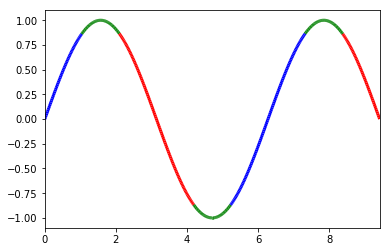

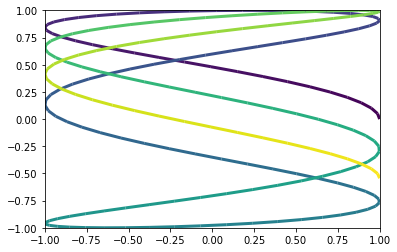

In [58]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm

x = np.linspace(0, 3 * np.pi, 500)
y = np.sin(x)
z = np.cos(0.5 * (x[:-1] + x[1:]))  # first derivative

# Create a colormap for red, green and blue and a norm to color
# f' < -0.5 red, f' > 0.5 blue, and the rest green
cmap = ListedColormap(['r', 'g', 'b'])
norm = BoundaryNorm([-1, -0.5, 0.5, 1], cmap.N)

# Create a set of line segments so that we can color them individually
# This creates the points as a N x 1 x 2 array so that we can stack points
# together easily to get the segments. The segments array for line collection
# needs to be numlines x points per line x 2 (x and y)
points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

# Create the line collection object, setting the colormapping parameters.
# Have to set the actual values used for colormapping separately.
lc = LineCollection(segments, cmap=cmap, norm=norm)
lc.set_array(z)
lc.set_linewidth(3)

fig1 = plt.figure()
plt.gca().add_collection(lc)
plt.xlim(x.min(), x.max())
plt.ylim(-1.1, 1.1)

# Now do a second plot coloring the curve using a continuous colormap
t = np.linspace(0, 10, 200)
x = np.cos(np.pi * t)
y = np.sin(t)
points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

lc = LineCollection(segments, cmap=plt.get_cmap('viridis'),
                    norm=plt.Normalize(0, 10))
lc.set_array(t)
lc.set_linewidth(3)

fig2 = plt.figure()
plt.gca().add_collection(lc)
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.show()